# Laboratory 3 - Nonparametric regression models

**Statistical Learning Methods**

**Author:** Łukasz Kraiński 

**Email:** lukasz.krainski123@gmail.com

[Repository](https://github.com/KrainskiL/SLM_S1920/Class3)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Splines" data-toc-modified-id="Splines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Splines</a></span></li><li><span><a href="#Local-regression" data-toc-modified-id="Local-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Local regression</a></span></li><li><span><a href="#Generalized-additive-models" data-toc-modified-id="Generalized-additive-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generalized additive models</a></span></li></ul></div>

## EDA

In [1]:
# !pip install csaps
# !pip install pygam

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import math
from scipy import stats
from scipy.interpolate import interp1d
import csaps
import copy
import statsmodels.api as sm
from pygam import LogisticGAM, l, s, f
from sklearn.datasets import load_breast_cancer
%matplotlib inline 

<br>

**Import and explore data**

In [3]:
dataset = pd.read_fwf("https://raw.githubusercontent.com/KrainskiL/SLM_S1920/master/Class3/DATA4-12.txt", 
                     names = ["MORT", "INCC", "POV", "EDU1", "EDU2", "ALCC",
                     "TOBC", "HEXC", "PHYS", "URB", "AGED"])
dataset.head()

,MORT,INCC,POV,EDU1,EDU2,ALCC,TOBC,HEXC,PHYS,URB,AGED
0,934.9,10673,0.189,0.565,0.122,1.90,114.5,1620,142,0.675,0.122
1,396.2,18187,0.107,0.825,0.211,3.86,128.9,1667,127,0.417,0.034
2,771.5,12795,0.132,0.724,0.174,3.08,107.1,1473,184,0.764,0.123
3,1022.8,10476,0.190,0.555,0.108,1.78,125.8,1552,136,0.397,0.149
4,766.0,16065,0.114,0.735,0.196,3.19,102.8,2069,235,0.957,0.106


**Descriptive statistics**

In [4]:
dataset.describe()

,MORT,INCC,POV,EDU1,EDU2,ALCC,TOBC,HEXC,PHYS,URB,AGED
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,855.005882,13249.235294,0.126176,0.674608,0.163157,2.712745,120.527451,1738.098039,186.980392,0.645176,0.119039
std,137.965956,2159.567842,0.035329,0.074939,0.033415,0.773501,22.130496,387.621065,68.146751,0.223298,0.021679
min,396.200000,9187.000000,0.079000,0.531000,0.104000,1.530000,66.500000,1203.000000,117.000000,0.200000,0.034000
25%,803.350000,11445.500000,0.101000,0.630500,0.139000,2.255000,109.250000,1530.500000,152.000000,0.468500,0.106000
50%,876.300000,13228.000000,0.118000,0.679000,0.158000,2.630000,118.600000,1671.000000,173.000000,0.671000,0.121000
75%,937.850000,14380.000000,0.147500,0.732000,0.182500,2.960000,128.300000,1863.000000,197.500000,0.816500,0.133000
max,1120.500000,18187.000000,0.239000,0.825000,0.275000,5.340000,201.100000,3872.000000,552.000000,1.000000,0.177000


<br>

**Correlation matrices**

More about plotting correlation matrices:
https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [5]:
corr = dataset.corr()
corr

,MORT,INCC,POV,EDU1,EDU2,ALCC,TOBC,HEXC,PHYS,URB,AGED
MORT,1.000000,-0.063307,0.263247,-0.515200,-0.362776,-0.125585,0.286770,0.430230,0.309109,0.126527,0.871566
INCC,-0.063307,1.000000,-0.540693,0.450367,0.714793,0.612729,0.086163,0.597501,0.640247,0.628745,-0.146688
POV,0.263247,-0.540693,1.000000,-0.707669,-0.365753,-0.257481,0.038679,-0.003537,-0.066548,-0.288107,0.065743
EDU1,-0.515200,0.450367,-0.707669,1.000000,0.637677,0.404977,-0.335654,0.054961,0.084199,0.050435,-0.308145
EDU2,-0.362776,0.714793,-0.365753,0.637677,1.000000,0.579781,-0.229275,0.442246,0.670224,0.396876,-0.376840
ALCC,-0.125585,0.612729,-0.257481,0.404977,0.579781,1.000000,0.285283,0.493273,0.490781,0.288536,-0.225887
TOBC,0.286770,0.086163,0.038679,-0.335654,-0.229275,0.285283,1.000000,-0.028807,-0.020800,-0.066872,0.056849
HEXC,0.430230,0.597501,-0.003537,0.054961,0.442246,0.493273,-0.028807,1.000000,0.837386,0.514984,0.225051
PHYS,0.309109,0.640247,-0.066548,0.084199,0.670224,0.490781,-0.020800,0.837386,1.000000,0.604466,0.122623
URB,0.126527,0.628745,-0.288107,0.050435,0.396876,0.288536,-0.066872,0.514984,0.604466,1.000000,0.071509


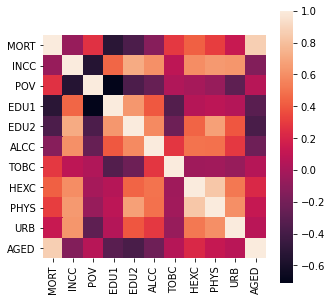

In [6]:
plt.rcParams['figure.figsize'] = [5,5]
ax = sns.heatmap(corr, square = True)

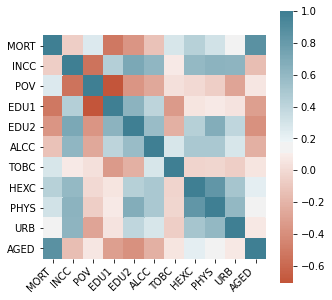

In [7]:
#https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
plt.rcParams['figure.figsize'] = [5,5]
ax = sns.heatmap(corr, square = True, cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

In [8]:
#Changing square size to show correlation strength
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=(size * size_scale).abs(), # Vector of square sizes, proportional to size parameter
        c=size* size_scale,
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

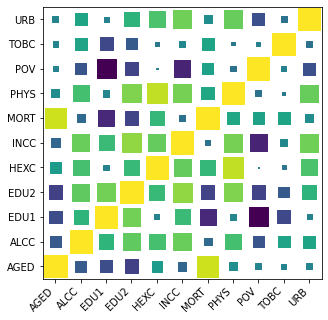

In [9]:
corr = dataset.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value']
)

In [10]:
#Caluclating p-value for each correlation value
corr = dataset.corr()
corr_new = copy.deepcopy(corr)
corr_p = copy.deepcopy(corr)
for i in np.arange(1,corr.shape[0]):
    for j in np.arange(1,corr.shape[1]):
        corr_p.iloc[i,j] = stats.stats.pearsonr( dataset[corr.index.values[i]], dataset[corr.columns[j]] )[1]

In [11]:
indices = corr_p > 0.05
corr_new[indices] = 0
corr_new

,MORT,INCC,POV,EDU1,EDU2,ALCC,TOBC,HEXC,PHYS,URB,AGED
MORT,0.000000,-0.063307,0.000000,-0.515200,-0.362776,-0.125585,0.000000,0.000000,0.000000,0.000000,0.000000
INCC,-0.063307,1.000000,-0.540693,0.450367,0.714793,0.612729,0.000000,0.597501,0.640247,0.628745,0.000000
POV,0.000000,-0.540693,1.000000,-0.707669,-0.365753,0.000000,0.000000,0.000000,0.000000,-0.288107,0.000000
EDU1,-0.515200,0.450367,-0.707669,1.000000,0.637677,0.404977,-0.335654,0.000000,0.000000,0.000000,-0.308145
EDU2,-0.362776,0.714793,-0.365753,0.637677,1.000000,0.579781,0.000000,0.442246,0.670224,0.396876,-0.376840
ALCC,-0.125585,0.612729,0.000000,0.404977,0.579781,1.000000,0.285283,0.493273,0.490781,0.288536,0.000000
TOBC,0.000000,0.000000,0.000000,-0.335654,0.000000,0.285283,1.000000,0.000000,0.000000,0.000000,0.000000
HEXC,0.000000,0.597501,0.000000,0.000000,0.442246,0.493273,0.000000,1.000000,0.837386,0.514984,0.000000
PHYS,0.000000,0.640247,0.000000,0.000000,0.670224,0.490781,0.000000,0.837386,1.000000,0.604466,0.000000
URB,0.000000,0.628745,-0.288107,0.000000,0.396876,0.288536,0.000000,0.514984,0.604466,1.000000,0.000000


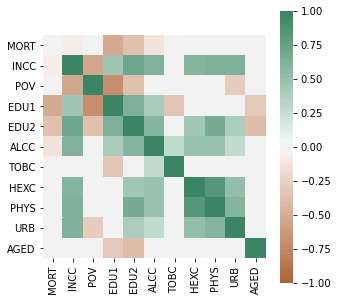

In [12]:
plt.rcParams['figure.figsize'] = [5,5]
ax = sns.heatmap(corr_new, square = True,
                vmin = -1, vmax = 1, center = 0,
                cmap=sns.diverging_palette(30, 150, n=200))

**Boxplots**

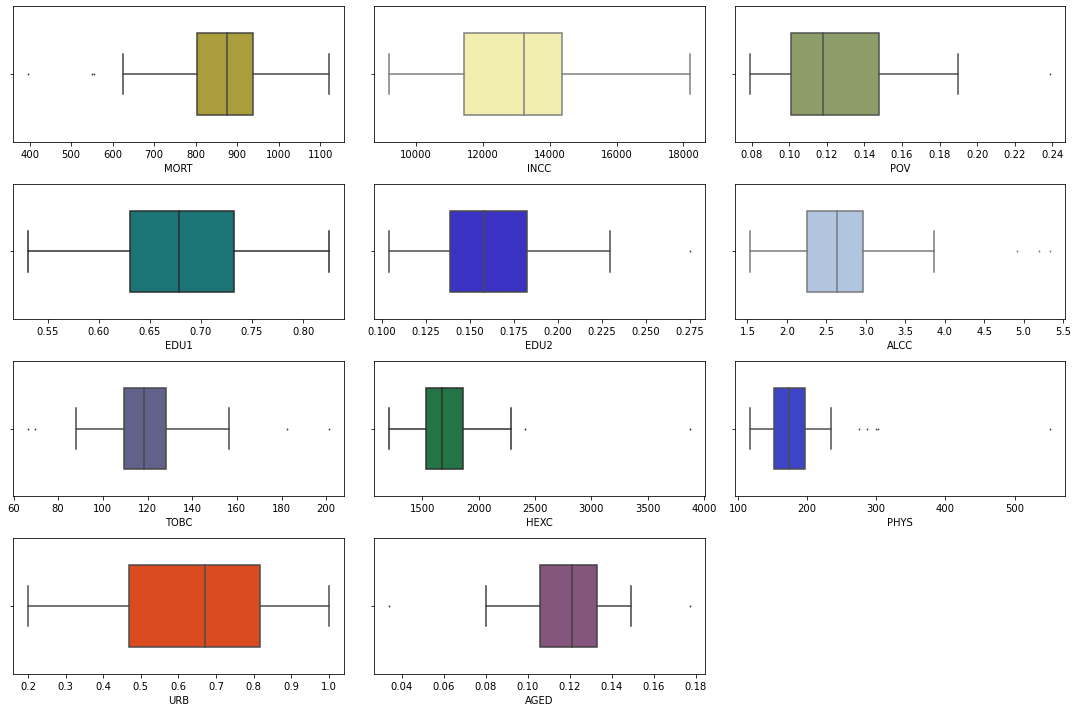

In [13]:
fig, axes = plt.subplots(4,3,figsize=[15,10])
num_cols=dataset.select_dtypes(include=np.number).columns
for i, col in enumerate(num_cols):
    sns.boxplot(x=col,color=np.random.rand(3,), data=dataset, ax=axes[i//3,i%3],fliersize=1,width=0.6)
fig.delaxes(axes[3,2])
plt.tight_layout()

**Histograms with density estimate**

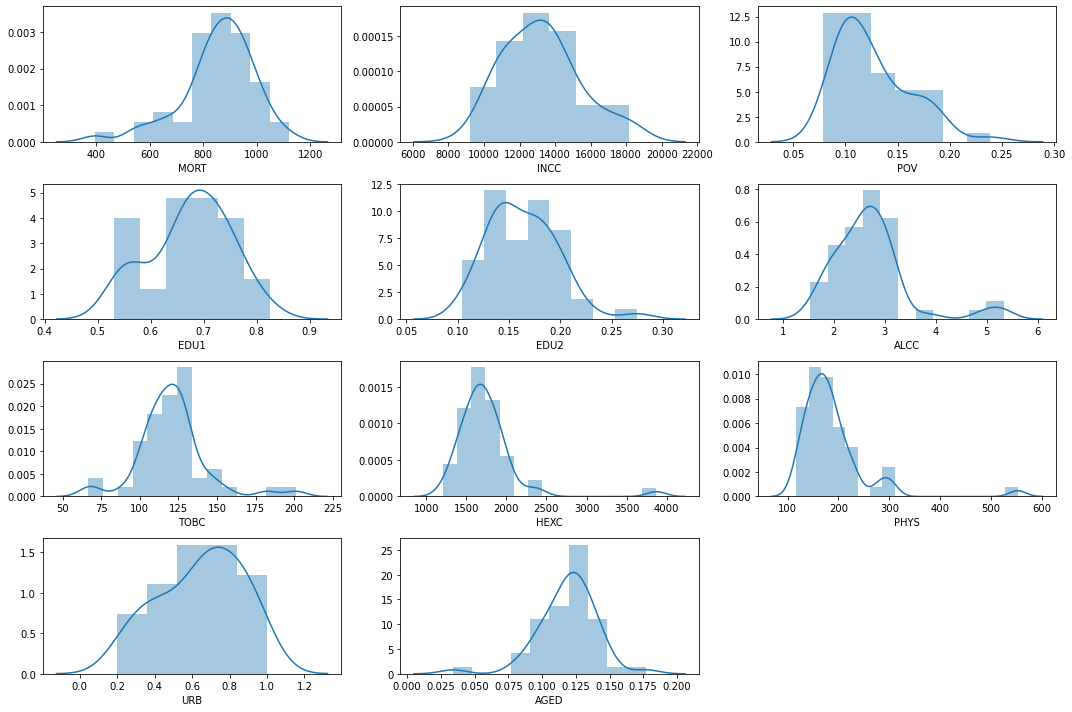

In [14]:
fig, axes = plt.subplots(4,3,figsize=[15,10])
num_cols=dataset.select_dtypes(include=np.number).columns
for i, col in enumerate(num_cols):
    sns.distplot(dataset[col],ax=axes[i//3,i%3])
fig.delaxes(axes[3,2])
plt.tight_layout()

<br>

**Scatterplots**

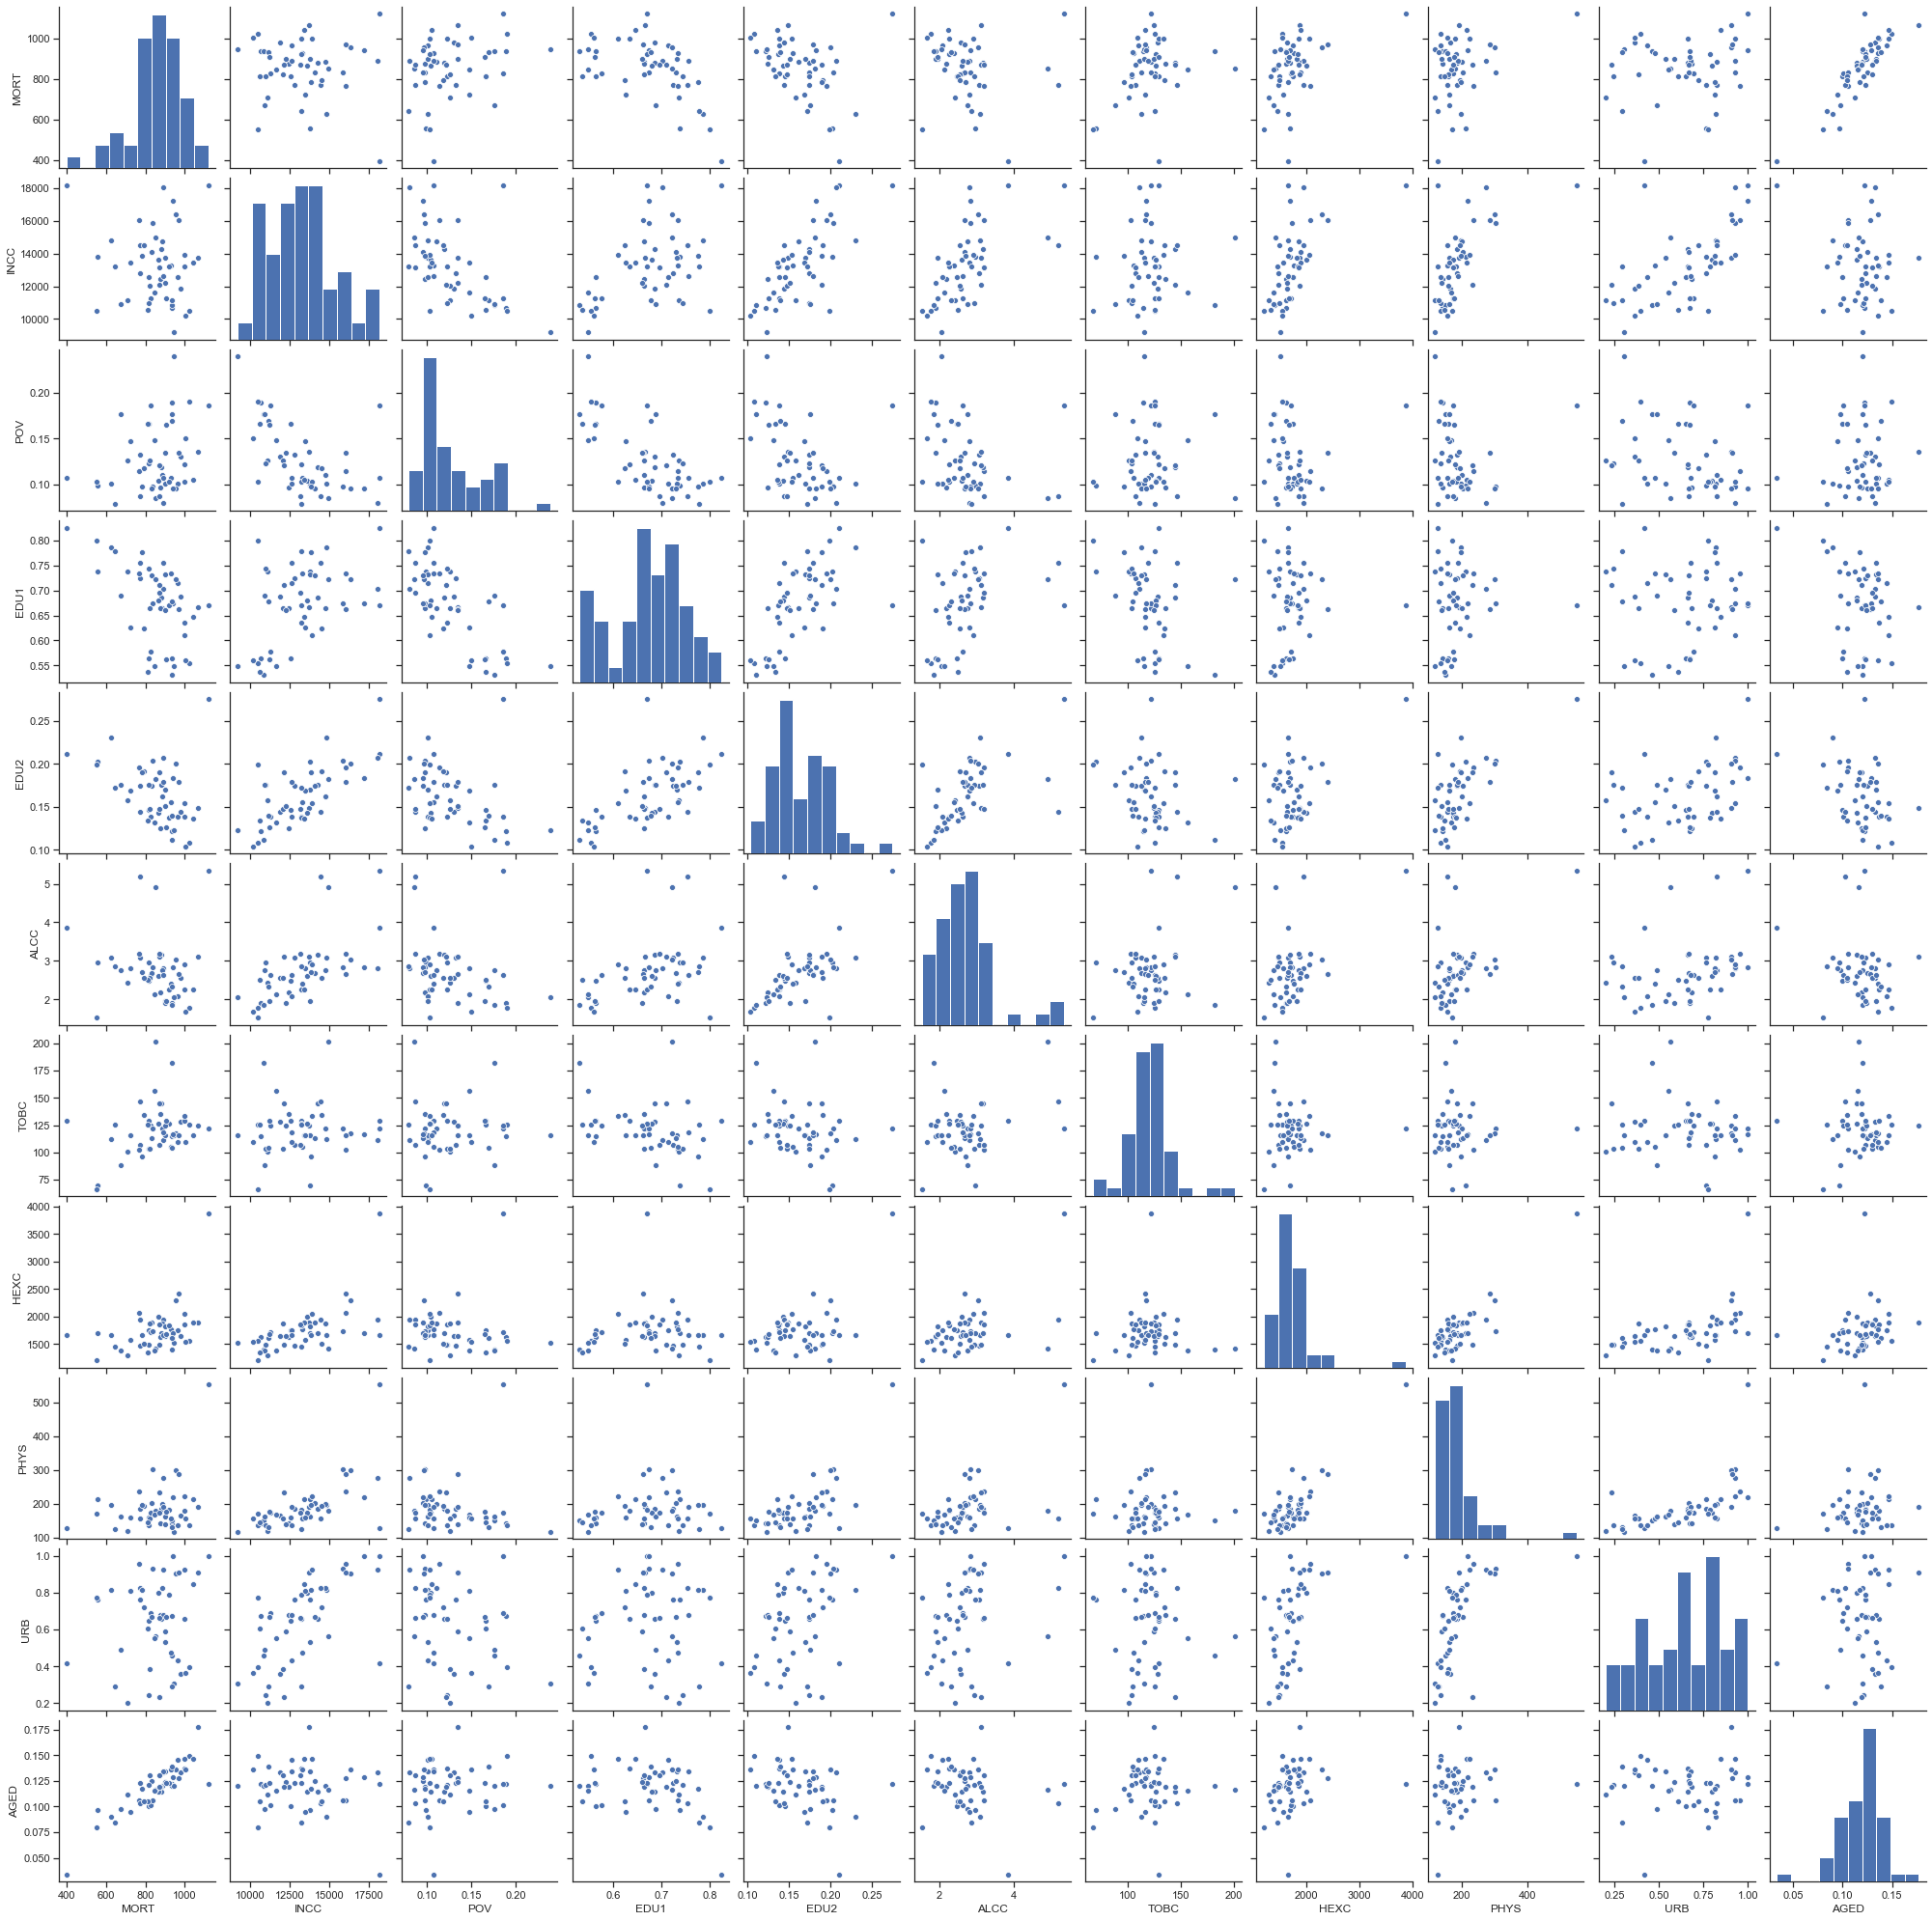

In [15]:
sns.set(style = "ticks")
sns.pairplot(dataset);

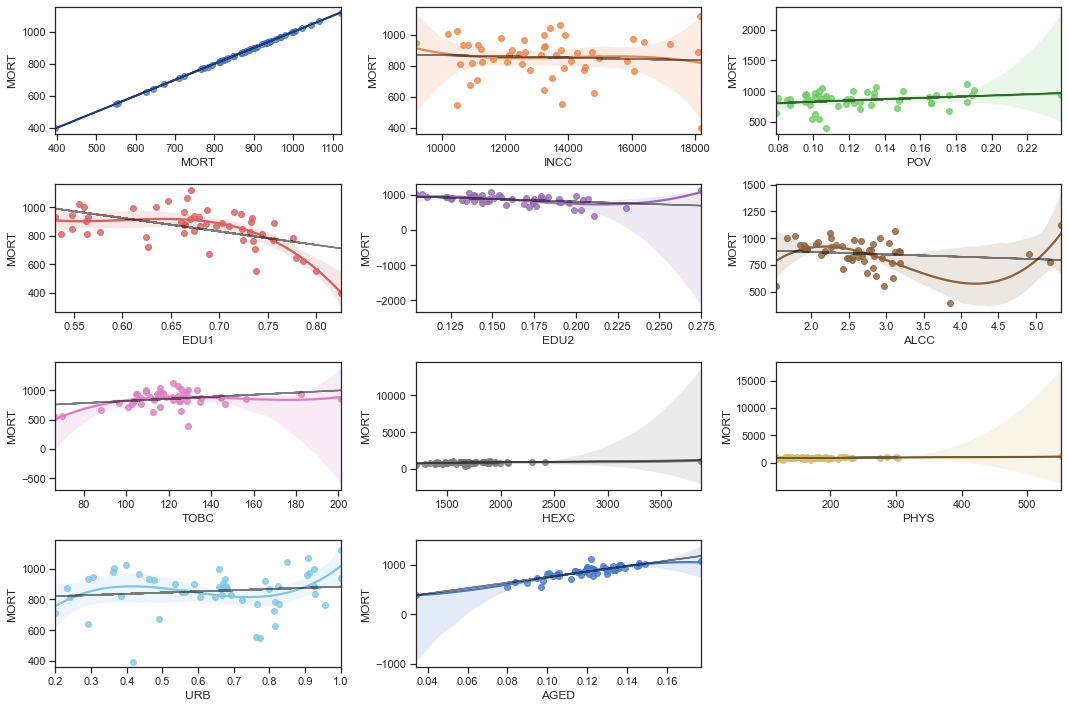

In [16]:
fig, axes = plt.subplots(4,3,figsize=[15,10])
for i, col in enumerate(num_cols):
    c_ax=axes[i//3,i%3]
    sns.regplot(x=col,y='MORT',color=sns.color_palette("muted", n_colors=11)[i], 
                data=dataset, ax=c_ax, order=3)
    slope, intercept, *_ = stats.linregress(dataset[col],dataset['MORT'])
    line = slope*dataset[col]+intercept
    c_ax.plot(dataset[col], line, 'black', alpha=0.5)
fig.delaxes(axes[3,2])
plt.tight_layout()

## Splines

Smoothing spline $f(x)$ is calculated by optimization of following formula:
$$\sum_{i=1}^N(y_i-f(x_i))^2+\lambda \int_D(f^{''}(t))^2\textit{d}t \rightarrow min$$

where $\lambda$ is smoothing parameter . Optimal solution of above formula is always continous spline consisted of cubic polynomials.

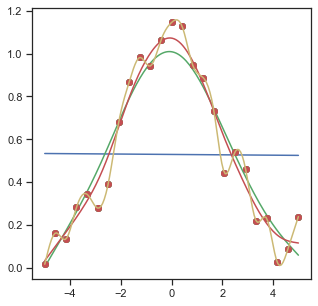

In [17]:
np.random.seed(1234)

x = np.linspace(-5., 5., 25)
y = np.exp(-(x/2.5)**2) + (np.random.rand(25) - 0.2) * 0.3
clrs = ['b','g','r','y']
for i in range(4):
    sp = csaps.CubicSmoothingSpline(x, y, smooth = i/3)
    xs = np.linspace(x[0], x[-1], 150)
    ys = sp(xs)
    plt.plot(x, y, 'o', xs, ys, clrs[i]+'-')
plt.show()

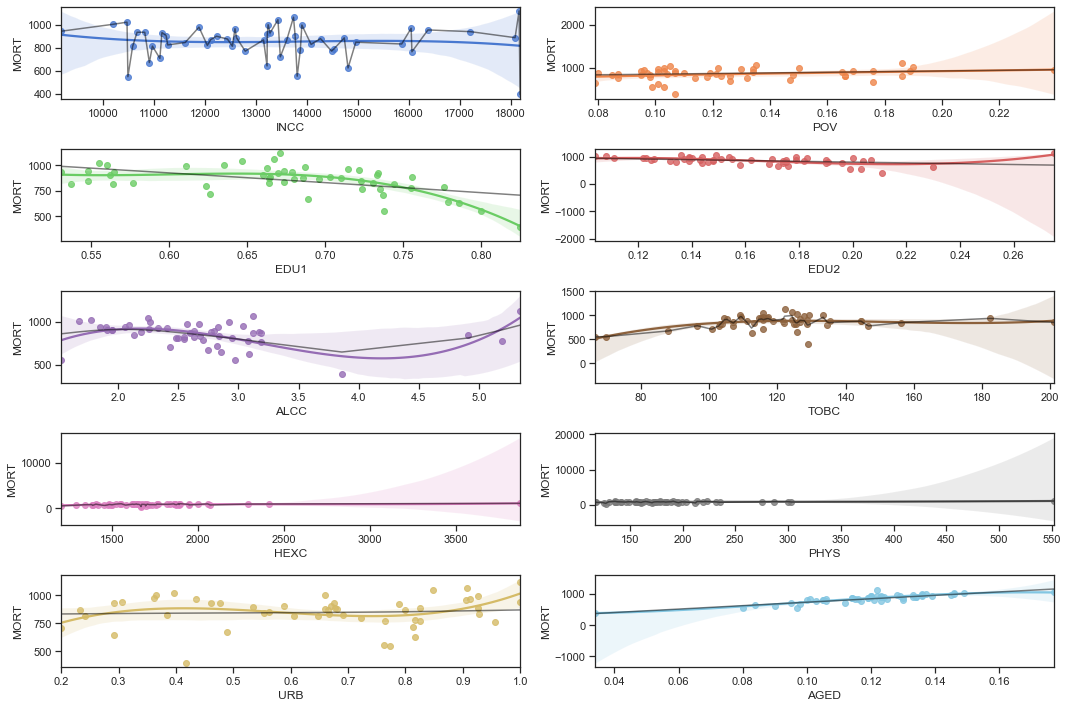

In [18]:
fig, axes = plt.subplots(5,2,figsize=[15,10])
for i, col in enumerate(num_cols[1:]):
    c_ax=axes[i//2,i%2]
    sns.regplot(x=col,y='MORT',color=sns.color_palette("muted", n_colors=11)[i], 
                data=dataset, ax=c_ax, order=3)
    srted = dataset[[col,'MORT']].sort_values(by=col).drop_duplicates(subset=col)
    spline = csaps.CubicSmoothingSpline(srted[col],srted['MORT'], smooth=0.85)(srted[col])
    c_ax.plot(srted[col], spline, 'black', alpha=0.5)
plt.tight_layout()

## Local regression

Local regression (LOESS) work as follows:

For any given point $x_0$ prediction of second degree LOESS (default for `loess` function in R) is defined by formula:

$$\hat{f}(x_0)=\hat{\alpha}(x_0)+\hat{\beta}(x_0)x_0+\hat{\gamma}(x_0)x_0^2$$

Coefficients $\alpha,\beta,\gamma$ are calculated for given point $x_0$ and are obtained through optimization task:

$$\min_{\alpha(x_0),\beta(x_0),\gamma(x_0)} \sum_{i=1}^NK_{\lambda}(x_0,x_i)\left(\alpha(x_0)+\beta(x_0)x_i+\gamma(x_0)x_i^2-y_i\right)^2$$

where $K_{\lambda}$ is defined as:

$$K_{\lambda}(x_0,x_i)=\phi\left(\frac{|x_0-x_i|}{\lambda}\right)$$

In [19]:
housing = pd.read_fwf("http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data",
                      names=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT','MEDV'])

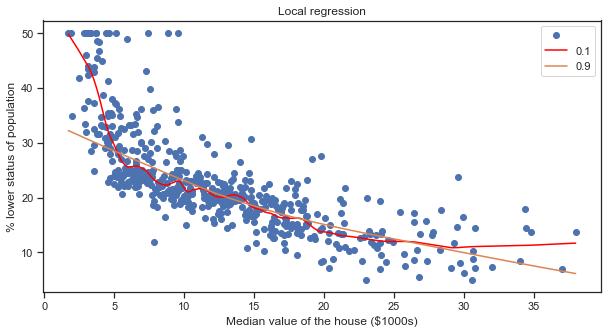

In [20]:
plt.rcParams['figure.figsize'] = [10,5]
lstat_grid = np.linspace(np.asarray(min(housing['LSTAT'])), np.asarray(max(housing['LSTAT'])), 200)

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(housing['MEDV'], housing['LSTAT'], frac=.1)
lowess2 = sm.nonparametric.lowess(housing['MEDV'], housing['LSTAT'], frac=.9)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(lstat_grid)

lowess_x2 = list(zip(*lowess2))[0]
lowess_y2 = list(zip(*lowess2))[1]
f2 = interp1d(lowess_x2, lowess_y2, bounds_error=False)
ynew2 = f2(lstat_grid)

plt.plot(housing['LSTAT'], housing['MEDV'], 'o')
plt.plot(lstat_grid, ynew, '-', color = "red")
plt.plot(lstat_grid, ynew2, '-')
plt.title("Local regression")
plt.xlabel("Median value of the house ($1000s)")
plt.ylabel("% lower status of population")
plt.legend(['','0.1', '0.9'])
plt.show()

## Generalized additive models

https://pygam.readthedocs.io/en/latest/api/gam.html

**GLM**

$$g(E_Y(y|x))=\beta_0+\beta_1{}x_{1}+\ldots{}\beta_p{}x_{p}$$

$g()$ is a link function. For example in logistic regression:

$$ln\left(\frac{E_Y(y|x)}{1-E_Y(y|x)}\right)=ln\left(\frac{P(y=1|x)}{1-P(y=1|x)}\right)=x^{T}\beta$$

**GAM**

$$g(E_Y(y|x))=\beta_0+f_1(x_{1})+f_2(x_{2})+\ldots+f_p(x_{p})$$

In [21]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
y = pd.Series(cancer.target)

In [22]:
X = cancer_df.iloc[:,0:3]
X

,mean radius,mean texture,mean perimeter
0,17.99,10.38,122.80
1,20.57,17.77,132.90
2,19.69,21.25,130.00
3,11.42,20.38,77.58
4,20.29,14.34,135.10
...,...,...,...
564,21.56,22.39,142.00
565,20.13,28.25,131.20
566,16.60,28.08,108.30
567,20.60,29.33,140.10


In [23]:
# l - linear, s - spline
# others: f - factor, te - tensor
gam = LogisticGAM(l(0) + s(1) + s(2)).fit(X, y)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.3172
Link Function:                        LogitLink Log Likelihood:                                  -103.2047
Number of Samples:                          569 AIC:                                              227.0437
                                                AICc:                                             227.5445
                                                UBRE:                                               2.4135
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7253
Feature Function                  Lam

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  after removing the cwd from sys.path.


In [24]:
gam.accuracy(X, y)

0.9244288224956063

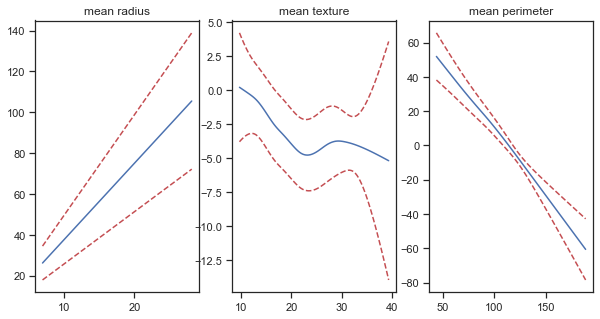

In [25]:
fig, axs = plt.subplots(1, X.shape[1])
titles = X.columns

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);